# Adaboost Implementation

Implementation of AdaBoost from scratch and applying it to spambase dataset found at https://archive.ics.uci.edu/ml/datasets/spambase to classify a given email as not-spam or spam 

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import warnings

In [96]:
# accuracy computation
def accuracy(y, pred):
    return np.sum(y == pred) / float(len(y)) 

In [35]:
def parse_spambase_data(filename):
    """
    Seperate dependent and independent variables
    """
    data = np.genfromtxt(filename, delimiter=',')
    _ , c =data.shape
    
    X = data[:,0:c-1]
    
    Y = data[:,c-1]
    Y[Y == 0] = -1
    return X, Y

# Adaboost implementation

In [8]:
def adaboost(X, y, num_iter):
    """
    input
    X: numpy matrix X (predictors)
    y: array y (labels: -1,1) num_iter return trees and weights
    num_iter: iterations
   
    Outputs: 
    array of trees from DecisionTreeClassifier
    array of tree_weights
    """
    trees = []
    trees_weights = [] 
    N, _ = X.shape
    d = np.ones(N) / N
    
    for i in range(num_iter):
        dt = DecisionTreeClassifier(max_depth=1, random_state=0)
        dt.fit(X,y,sample_weight = d)
        
        preds = dt.predict(X)
        err = np.sum(d[y != preds])/np.sum(d)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            alpha = np.log((1-err)/err)
            if np.isinf(alpha): alpha = 1
            
        d = d*np.exp(alpha*(y != preds).astype(float))
        
        trees.append(dt)
        trees_weights.append(alpha)

    return trees, trees_weights

In [11]:
def adaboost_predict(X, trees, trees_weights):
    """Given X, trees and weights predict y
    """
    # X input, y output
    N, _ =  X.shape
    y = np.zeros(N)
    # YOUR CODE HERE
    for i in range(len(trees)):
        y += (trees[i].predict(X))*trees_weights[i]
    #raise NotImplementedError()
    return [-1 if yi<=0 else 1 for yi in y]

# Train on spambase data

In [13]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")
trees, trees_weights = adaboost(X, Y, 10)
Yhat = adaboost_predict(X, trees, trees_weights)
Yhat_test = adaboost_predict(X_test, trees, trees_weights)
    
acc_test = accuracy(Y_test, Yhat_test)
acc_train = accuracy(Y, Yhat)
print("Train Accuracy %.4f" % acc_train)
print("Test Accuracy %.4f" % acc_test)

Train Accuracy 0.9111
Test Accuracy 0.9190


# Experiment to find optimum number of trees

In [14]:
#create validation set
val_ind = np.random.choice(range(X.shape[0]), X.shape[0], replace=False)

x_val = X[val_ind[0:720]]
x_train = X[val_ind[720:]]

y_val = Y[val_ind[0:720]]
y_train = Y[val_ind[720:]]

In [17]:
# experiment
def adaboost_experiment(x_train, x_val, y_train, y_val, num_iter):
    trees = []
    trees_weights = [] 
    N, _ = x_train.shape
    d = np.ones(N) / N
    acc_train = []
    acc_val = []
    
    for i in range(num_iter):
        dt = DecisionTreeClassifier(max_depth=1, random_state=0)
        dt.fit(x_train,y_train,sample_weight = d)
        
        preds = dt.predict(x_train)
        err = np.sum(d[y_train != preds])/np.sum(d)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            alpha = np.log((1-err)/err)
            if np.isinf(alpha): alpha = 1
            
        d = d*np.exp(alpha*(y_train != preds).astype(float))
        
        trees.append(dt)
        trees_weights.append(alpha)
        
        adaboost_predict(x_train, trees, trees_weights)
        
        acc_train.append(accuracy(y_train, adaboost_predict(x_train, trees, trees_weights)))
        acc_val.append(accuracy(y_val, adaboost_predict(x_val, trees, trees_weights)))
        
    return acc_train, acc_val

In [ ]:
acc_train, acc_val = adaboost_experiment(x_train, x_val, y_train, y_val, 500)

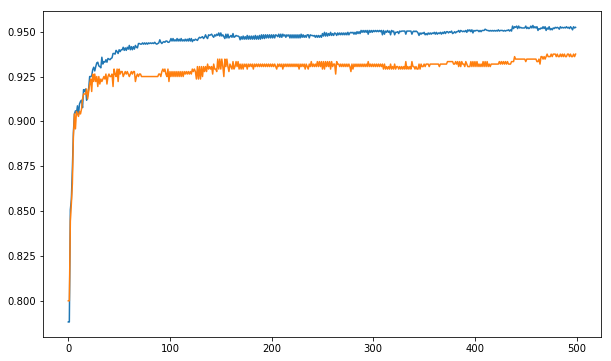

In [19]:
import matplotlib.pyplot as plt

t = np.arange(len(acc_train))
plt.figure(figsize=(10,6))
plt.plot(t, np.array(acc_train), t, np.array(acc_val))

plt.show()

In [20]:
np.argmax(acc_val), np.max(acc_val)

(471, 0.9375)

From the above it can be seen that after about 150 trees, validation error (in orange) flattens out and with not much improvement. Maximum validation accuracy is reached at 470 trees. So in order avoid any overfitting best number of trees for adaboost model can be deemed 150

In [21]:
np.save('acc_val', acc_val)
np.save('acc_trn', acc_train)

# Using XGBoost as an alternative method

Using XGBoost for comparison and see how model performs with different hyper parameter changes

In [95]:
from xgboost import XGBClassifier

In [50]:
xgb = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=150, n_jobs=-1, 
                    subsample=0.8)
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [51]:
accuracy(y_val, xgb.predict(x_val))

0.95416666666666672

XGboost with above parameters provides a better validation set accuracy compared to Adaboost

In [93]:
# plots for how XGBoost performs with different parameter values
max_depth=[1,2,5,10,20]
learning_rate = [0.01, 0.1, 0.2, 0.5, 0.99]
n_estimators = [5,10,20,50,100]
sub_sample = [0.2,0.4, 0.6, 0.8, 1.0]

In [94]:
X, Y = parse_spambase_data("spambase.train")
X_test, Y_test = parse_spambase_data("spambase.test")

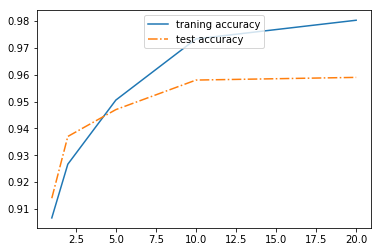

In [127]:
acc_train = []
acc_val = []
for i in max_depth:
    xgb = XGBClassifier(max_depth=i, learning_rate=0.2, n_estimators=20, n_jobs=-1, 
                        subsample=0.5)
    xgb.fit(X, Y)
    
    acc_train.append(accuracy(Y, xgb.predict(X)))
    acc_val.append(accuracy(Y_test, xgb.predict(X_test)))

import matplotlib.pyplot as plt

t = max_depth
fig, ax = plt.subplots()
ax.plot(t, np.array(acc_train), '-', label='traning accuracy')
ax.plot(t, np.array(acc_val), '-.', label='test accuracy')
legend = ax.legend(loc='upper center')
plt.show()

With same combination of other features, increasing the maxdepth eventually leads to overfitting

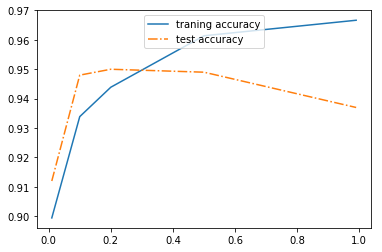

In [125]:
acc_train = []
acc_val = []
for i in learning_rate:
    xgb = XGBClassifier(max_depth=2, learning_rate=i, n_estimators=50, n_jobs=-1, 
                        subsample=0.5)
    xgb.fit(X, Y)
    
    acc_train.append(accuracy(Y, xgb.predict(X)))
    acc_val.append(accuracy(Y_test, xgb.predict(X_test)))

import matplotlib.pyplot as plt

t = learning_rate
fig, ax = plt.subplots()
ax.plot(t, np.array(acc_train), '-', label='traning accuracy')
ax.plot(t, np.array(acc_val), '-.', label='test accuracy')
legend = ax.legend(loc='upper center')
plt.show()

With same combination other features, increasing the learning rate eventually leads to overfitting

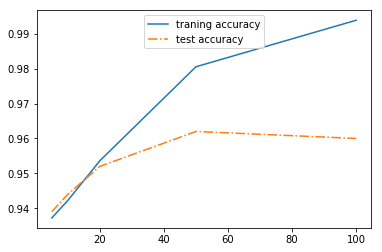

In [126]:
acc_train = []
acc_val = []
for i in n_estimators:
    xgb = XGBClassifier(max_depth=5, learning_rate=0.2, n_estimators=i, n_jobs=-1, 
                        subsample=0.7)
    xgb.fit(X, Y)
    
    acc_train.append(accuracy(Y, xgb.predict(X)))
    acc_val.append(accuracy(Y_test, xgb.predict(X_test)))

import matplotlib.pyplot as plt

t = n_estimators
fig, ax = plt.subplots()
ax.plot(t, np.array(acc_train), '-', label='traning accuracy')
ax.plot(t, np.array(acc_val), '-.', label='test accuracy')
legend = ax.legend(loc='upper center')

plt.show()

With same combination of other features, increasing the n_estimators eventually leads to overfitting

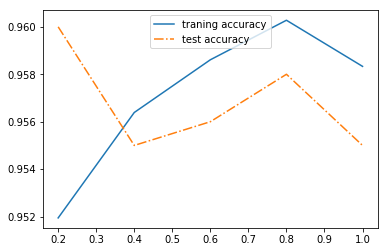

In [124]:
acc_train = []
acc_val = []
for i in sub_sample:
    xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, n_jobs=-1, 
                        subsample=i)
    xgb.fit(X, Y)
    
    acc_train.append(accuracy(Y, xgb.predict(X)))
    acc_val.append(accuracy(Y_test, xgb.predict(X_test)))

import matplotlib.pyplot as plt

t = sub_sample
fig, ax = plt.subplots()
ax.plot(t, np.array(acc_train), '-', label='traning accuracy')
ax.plot(t, np.array(acc_val), '-.', label='test accuracy')
legend = ax.legend(loc='upper center')

plt.show()

Cannot really comment about subsample rate. Still increasing the subsample rate leads to less variation in the trees, which possibly lead to overfitting